In [1]:
# ! pip install -e ../../savo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy as copy
from scipy import optimize
import torch

import sys
sys.path.append('../')  #for savo import
sys.path.append('../../machineIO/')  #for machineIO import
from savo.model import GaussianProcess as GP
from machineIO.util import plot_2D_projection

Failed to import 'epics'
Failed to import 'phantasy'


In [3]:
def quadratic(x, noise=0.0):
    x = torch.as_tensor(x)
    d = x.shape[-1]
    y = torch.sum(x**2, dim=-1) / d
    return 1 - y + torch.randn_like(y) * noise

In [4]:
def rosenbrock(x, noise=0.0):
    x = torch.as_tensor(x)
    return (x[:,1] - x[:,0]**2)**2 + (1 - x[:,0])**2/100

In [5]:
test_func = quadratic
# test_func = rosenbrock

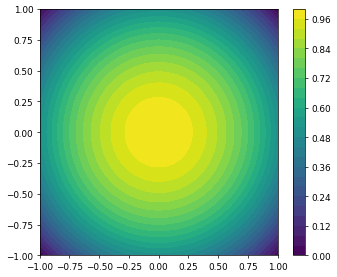

In [6]:
def plot_contour(figsize=(6,5),dpi=128):
    grid = np.linspace(-1,1,128)
    x1,x2 = np.meshgrid(grid,grid)
    xgrid = np.vstack((x1.flatten(), x2.flatten())).T
    ygrid = test_func(xgrid,noise=0)
    fig,ax = plt.subplots(figsize=figsize,dpi=dpi)
    cs = ax.tricontourf(xgrid[:,0],xgrid[:,1],ygrid,levels=32)
    fig.colorbar(cs,ax=ax)
    return fig,ax
fig,ax = plot_contour(dpi=64)

# check gradint of mean by autograd vs sample average vs grad posterior

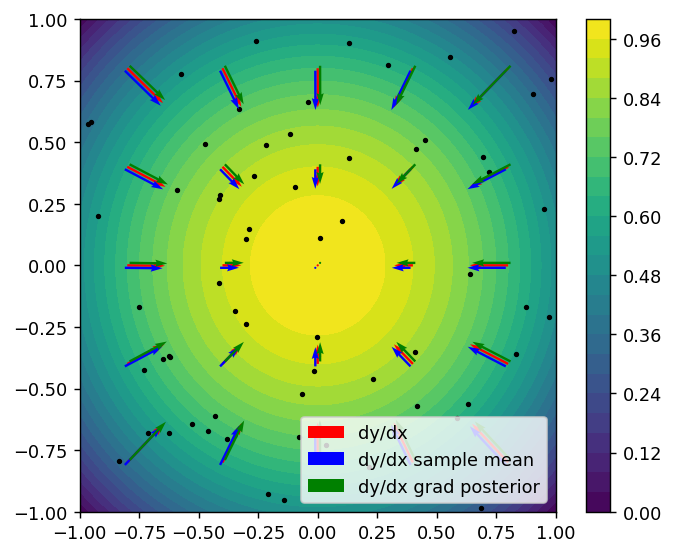

In [7]:
n_train = 64
train_x = torch.rand(n_train,2,dtype=torch.double)*2-1
train_y = test_func(train_x).view(-1,1)*1
gp = GP(train_x, train_y)

grid = np.linspace(-0.8,0.8,5)
x1,x2 = np.meshgrid(grid,grid)
xgrid = torch.tensor(np.vstack((x1.flatten(), x2.flatten())).T,dtype=torch.double)
mean_ygrad = gp.get_grad(xgrid,n_samples=1)
sample_ygrad = gp.get_grad(xgrid,n_samples=1024)
mean_posterior, sigma_posteriod = gp.get_gradient_posterior(xgrid)
X = xgrid[:, 0].numpy()
Y = xgrid[:, 1].numpy()
U1 = mean_ygrad[:, 0].numpy()
V1 = mean_ygrad[:, 1].numpy()
U2 = sample_ygrad[:, 0].numpy()
V2 = sample_ygrad[:, 1].numpy()
U3 = mean_posterior[:, 0].numpy()
V3 = mean_posterior[:, 1].numpy()
fig,ax = plot_contour(dpi=128)
ax.scatter(train_x[:,0],train_x[:,1],c='k',s=4)
ax.quiver(X, Y, U1, V1, color='red', angles='xy', scale_units='xy', scale=5, width=0.005, label='dy/dx')
ax.quiver(X - 0.01, Y - 0.01, U2, V2, color='blue', angles='xy', scale_units='xy', scale=5, width=0.005, label='dy/dx sample mean')
ax.quiver(X + 0.01, Y + 0.01, U3, V3, color='green', angles='xy', scale_units='xy', scale=5, width=0.005, label='dy/dx grad posterior')
ax.legend()

# gradient of mean vs most probable descent

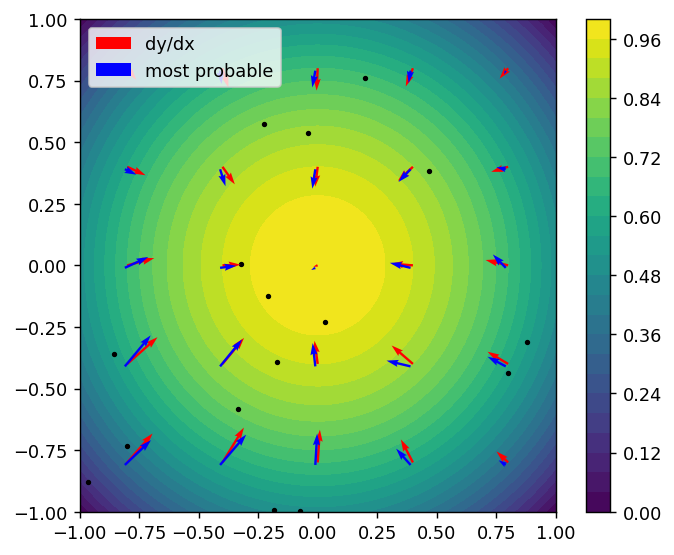

In [8]:
# small training data -> large uncertainty
n_train = 16
train_x = torch.rand(n_train,2,dtype=torch.double)*2-1
train_y = test_func(train_x).view(-1,1)*1
gp = GP(train_x, train_y)

grid = np.linspace(-0.8,0.8,5)
x1,x2 = np.meshgrid(grid,grid)
xgrid = torch.tensor(np.vstack((x1.flatten(), x2.flatten())).T,dtype=torch.double)
mean_ygrad = gp.get_grad(xgrid,n_samples=1)
maximum_probable_gradient, probability = gp.get_maximum_probable_gradient(xgrid)
X = xgrid[:, 0].numpy()
Y = xgrid[:, 1].numpy()
U1 = mean_ygrad[:, 0].numpy()
V1 = mean_ygrad[:, 1].numpy()
U2 = maximum_probable_gradient[:, 0].numpy()*probability.numpy()
V2 = maximum_probable_gradient[:, 1].numpy()*probability.numpy()
fig,ax = plot_contour(dpi=128)
ax.scatter(train_x[:,0],train_x[:,1],c='k',s=4)
ax.quiver(X, Y, U1, V1, color='red', angles='xy', scale_units='xy', scale=5, width=0.005, label='dy/dx')
ax.quiver(X - 0.01, Y - 0.01, U2, V2, color='blue', angles='xy', scale_units='xy', scale=5, width=0.005, label='most probable')
ax.legend()
probability1 = probability

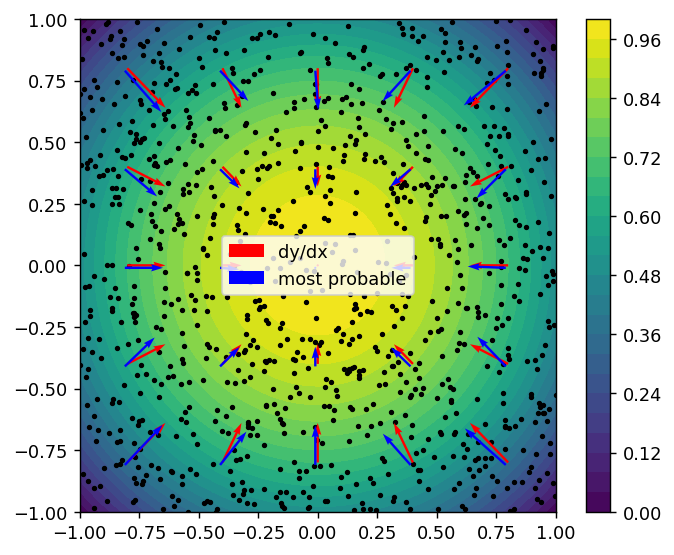

In [9]:
# largel training data -> small uncertainty
n_train = 1024
train_x = torch.rand(n_train,2,dtype=torch.double)*2-1
train_y = test_func(train_x).view(-1,1)*1
gp = GP(train_x, train_y)

grid = np.linspace(-0.8,0.8,5)
x1,x2 = np.meshgrid(grid,grid)
xgrid = torch.tensor(np.vstack((x1.flatten(), x2.flatten())).T,dtype=torch.double)
mean_ygrad = gp.get_grad(xgrid,n_samples=1)
maximum_probable_gradient, probability = gp.get_maximum_probable_gradient(xgrid)
X = xgrid[:, 0].numpy()
Y = xgrid[:, 1].numpy()
U1 = mean_ygrad[:, 0].numpy()
V1 = mean_ygrad[:, 1].numpy()
U2 = maximum_probable_gradient[:, 0].numpy()*probability.numpy()
V2 = maximum_probable_gradient[:, 1].numpy()*probability.numpy()
fig,ax = plot_contour(dpi=128)
ax.scatter(train_x[:,0],train_x[:,1],c='k',s=4)
ax.quiver(X, Y, U1, V1, color='red', angles='xy', scale_units='xy', scale=5, width=0.005, label='dy/dx')
ax.quiver(X - 0.01, Y - 0.01, U2, V2, color='blue', angles='xy', scale_units='xy', scale=5, width=0.005, label='most probable')
ax.legend()
probability2 = probability

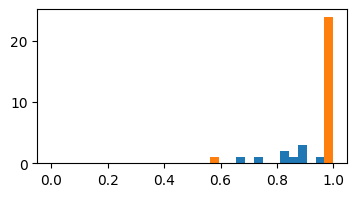

In [10]:
plt.figure(figsize=(4,2))
plt.hist(probability1,range=(0,1),bins=32);
plt.hist(probability2,range=(0,1),bins=32);